# Preamble

This notebook was designed to run on GoogleColab.

This notebook requires one input file to run (`answers.csv`, instructions for download below in **Read Data** section).

# Install
Install pyspark.

In [31]:
%pip install pyspark
%pip install pandas
%pip install matplotlib

# Import
Import modules and instantiate the global variables.

In [32]:
import pyspark
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StringType
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
spark = SparkSession.builder.appName('SENG550Project').getOrCreate()
sc = spark.sparkContext

# Read Data
Read the data from the .csv file.

**Please note**: for this step to work you must have downloaded `answers.csv` file from https://ics.uci.edu/~duboisc/stackoverflow/answers.csv (or take a copy from our repository of submission). You must now put this file into the folder in which GoogleColab executes (i.e., `/content`). You can put it there by simply dragging and dropping `answers.csv` into it.

In [33]:
df_pyspark = spark.read.option('header', 'true').csv('answers.csv')
df_pyspark = df_pyspark.repartition(100)
df_pyspark.show()

+------+------+-----+---+----------+--------------------+---+---+------+-----+---+----------+
|   _c0|   qid|    i| qs|        qt|                tags|qvc|qac|   aid|    j| as|        at|
+------+------+-----+---+----------+--------------------+---+---+------+-----+---+----------+
| 39295|620506|48789|  2|1236375123|      delphi,records|321|  5|623032|75188|  0|1236486582|
| 80135|680343|81419|  1|1237959599|ajax,rails,script...| 80|  1|680376|38426|  2|1237960597|
| 76039|674147| 4906|  0|1237826484|              vb,vb6|183|  4|674159|75694|  0|1237826668|
| 58809|648923|39036|  0|1237165483|best-practices,su...|207|  9|648936|16076|  1|1237166046|
|143886|775168| 4593|  6|1240357880|math,latex,mathml...|320| 12|775385|78374|  1|1240363859|
|100124|710127|86228|  0|1238684998|   objective-c,cocoa| 57|  2|710248|35999|  1|1238686469|
|150011|784417|70942|  1|1240544464|c,string,pointers...|663| 10|784436|47529|  1|1240544923|
|112497|728456| 8280|  2|1239162435|debugging,sop,phi...|161

In [34]:
# Print number of rows.
df_pyspark.count()

263540

In [35]:
# Print schema.
df_pyspark.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- qid: string (nullable = true)
 |-- i: string (nullable = true)
 |-- qs: string (nullable = true)
 |-- qt: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- qvc: string (nullable = true)
 |-- qac: string (nullable = true)
 |-- aid: string (nullable = true)
 |-- j: string (nullable = true)
 |-- as: string (nullable = true)
 |-- at: string (nullable = true)



# Transformation


## Column Names

First we are going to beautify the dataframe a little.

Let us begin with the column names. Currently, they are unreadable.

In [36]:
df_pyspark = df_pyspark.withColumnRenamed("qid", "question_id")
df_pyspark = df_pyspark.withColumnRenamed("i", "questioner_id")
df_pyspark = df_pyspark.withColumnRenamed("qs", "question_score")
df_pyspark = df_pyspark.withColumnRenamed("qt", "question_time")
# "tags" stay the same.
df_pyspark = df_pyspark.withColumnRenamed("qvc", "num_views")
df_pyspark = df_pyspark.withColumnRenamed("qac", "num_answers")
df_pyspark = df_pyspark.withColumnRenamed("aid", "answer_id")
df_pyspark = df_pyspark.withColumnRenamed("j", "answerer_id")
df_pyspark = df_pyspark.withColumnRenamed("as", "answer_score")
df_pyspark = df_pyspark.withColumnRenamed("at", "answer_time")

# Print top 5.
df_pyspark.show(5)


+------+-----------+-------------+--------------+-------------+--------------------+---------+-----------+---------+-----------+------------+-----------+
|   _c0|question_id|questioner_id|question_score|question_time|                tags|num_views|num_answers|answer_id|answerer_id|answer_score|answer_time|
+------+-----------+-------------+--------------+-------------+--------------------+---------+-----------+---------+-----------+------------+-----------+
| 39295|     620506|        48789|             2|   1236375123|      delphi,records|      321|          5|   623032|      75188|           0| 1236486582|
| 80135|     680343|        81419|             1|   1237959599|ajax,rails,script...|       80|          1|   680376|      38426|           2| 1237960597|
| 76039|     674147|         4906|             0|   1237826484|              vb,vb6|      183|          4|   674159|      75694|           0| 1237826668|
| 58809|     648923|        39036|             0|   1237165483|best-practice

## Schema

You may have noticed above that all the columns are nullable string types. That won't do.




In [37]:
from pyspark.sql.functions import col

# List all columns except 'tags'.
cols_to_cast = [c for c in df_pyspark.columns if c != 'tags']

# Cast columns to integer and handle conversion errors by turning invalid values into nulls.
df_pyspark = df_pyspark.select(
    [col(c).cast('integer').alias(c) if c in cols_to_cast else col(c) for c in df_pyspark.columns]
)
df_pyspark = df_pyspark.repartition(100)

Since this is data produced by a machine we can expect all column values to be present. If one is not present, clearly the data is corrupted. Remove those rows.

In [38]:
# Drop rows where any of the integer columns are null (conversion failed or original nulls).
df_pyspark = df_pyspark.dropna(subset=cols_to_cast)

Let us take a look at our data now.

In [39]:
df_pyspark.show(5)

+-----+-----------+-------------+--------------+-------------+--------------------+---------+-----------+---------+-----------+------------+-----------+
|  _c0|question_id|questioner_id|question_score|question_time|                tags|num_views|num_answers|answer_id|answerer_id|answer_score|answer_time|
+-----+-----------+-------------+--------------+-------------+--------------------+---------+-----------+---------+-----------+------------+-----------+
|63405|     655696|        57698|             4|   1237318707|teaching,learning...|      417|         21|   655707|       5812|           4| 1237319016|
|50948|     637636|        70716|             0|   1236842639|wpf,font,underlin...|      425|          1|   637711|        233|           3| 1236845834|
|14370|     584449|        70615|             1|   1235526736|java,swing,gui,ev...|       64|          2|   584459|      20029|           4| 1235527074|
|25688|     600770|        65764|             2|   1235949093|cocoa-touch,cocoa...

In [40]:
# Print number of rows.
df_pyspark.count()

263132

In [41]:
# Print schema.
df_pyspark.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- question_id: integer (nullable = true)
 |-- questioner_id: integer (nullable = true)
 |-- question_score: integer (nullable = true)
 |-- question_time: integer (nullable = true)
 |-- tags: string (nullable = true)
 |-- num_views: integer (nullable = true)
 |-- num_answers: integer (nullable = true)
 |-- answer_id: integer (nullable = true)
 |-- answerer_id: integer (nullable = true)
 |-- answer_score: integer (nullable = true)
 |-- answer_time: integer (nullable = true)



## Encoding

We are getting there. But one column is still problematic. Tags column needs to be one-hot encoded. In order to preserve the resources though, we will on hot encode this later, once we have grouped by the question.

# Aggregation

In [42]:
df = df_pyspark

# Compute the time to the first answer (tta) for each question
window_spec = Window.partitionBy("question_id").orderBy("answer_time")

# Add a column for the time to first answer (relative to question_time)
df = df.withColumn("tta", F.min(F.col("answer_time") - F.col("question_time")).over(window_spec))
df = df.withColumn("ttla", F.max(F.col("answer_time") - F.col("question_time")).over(window_spec))

# Add a column for the number of tags (num_tags)
# Splitting the tags column by commas and counting the resulting elements gives the total number of tags per question
df = df.withColumn("num_tags", F.size(F.split(F.col("tags"), ",")))

# Add a column for the time since the question was posted
# Set the fixed maximum date for the dataset (June 7, 2009 - as given in the dataset)
# Convert question_time (epoch) to DATE format, then calculate days since the question was posted
max_date = F.to_date(F.lit("2009-06-07"))
df = df.withColumn("question_date", F.to_date(F.from_unixtime(F.col("question_time")))) \
       .withColumn("time_since_posted", F.datediff(max_date, F.col("question_date")))

# Add temporal features: weekday and hour of day
# Extract the day of the week when the question was posted (1 = Sunday, 7 = Saturday)
# Extract the hour of the day (0-23) when the question was posted to capture patterns of activity
df = df.withColumn("weekday", F.dayofweek(F.col("question_date"))) \
       .withColumn("hour_of_day", F.hour(F.from_unixtime(F.col("question_time"))))

# Aggregate the results for each question_id
# Combine all the computed features along with the original attributes into a single DataFrame
result_df = df.groupBy("question_id").agg(
    F.first("questioner_id").alias("questioner_id"),  # User ID of the person who posted the question
    F.first("question_score").alias("question_score"),  # Community score of the question
    F.first("question_time").alias("question_time"),  # Timestamp of when the question was posted
    F.first("tags").alias("tags"),  # Original tags associated with the question
    F.first("num_views").alias("num_views"),  # Target variable: Number of views of the question
    F.first("num_answers").alias("num_answers"),  # Total number of answers to the question
    F.min("tta").alias("tta"),  # Time to the first answer (relative to question_time)
    F.max("ttla").alias("ttla"),  # Time to the last answer (relative to question_time)
    F.first("num_tags").alias("num_tags"),  # Number of tags associated with the question
    F.first("time_since_posted").alias("time_since_posted"),  # Total days since the question was posted
    F.first("weekday").alias("weekday"),  # Day of the week when the question was posted
    F.first("hour_of_day").alias("hour_of_day")  # Hour of the day when the question was posted
)

result_df = result_df.repartition(100)

# Display the first few rows of the aggregated DataFrame
result_df.show(5, truncate=False)


+-----------+-------------+--------------+-------------+----------------------------------------+---------+-----------+----+-------+--------+-----------------+-------+-----------+
|question_id|questioner_id|question_score|question_time|tags                                    |num_views|num_answers|tta |ttla   |num_tags|time_since_posted|weekday|hour_of_day|
+-----------+-------------+--------------+-------------+----------------------------------------+---------+-----------+----+-------+--------+-----------------+-------+-----------+
|953099     |114492       |0             |1244149593   |javascript                              |50       |2          |143 |295    |1       |3                |5      |21         |
|867754     |99268        |-1            |1242380156   |sqlserver2000,c#ûnet                    |19       |1          |299 |299    |2       |23               |6      |9          |
|887286     |4172         |3             |1242816897   |best-practices,design,project-management|195

In [43]:
result_df.count()

83342

Clearly we must reduce this number. 80k dimensions is not feasible for small-scale machine learning. We will only take the most common tags.

In [44]:
# Find all unique tags and
# Split the tags column into an array of tags, then explode it to get one tag per row
df = df.repartition(100) # repartition to redistribute the data on multiple partitions instead of one
tags_df = df.withColumn("tag", F.explode(F.split(F.col("tags"), ",")))

# Group by tag and count the occurrences
tag_counts_df = tags_df.groupBy("tag").agg(F.count("*").alias("count"))

tag_counts_df = tag_counts_df.repartition(100)

# Show the tags with their counts
tag_counts_df.orderBy(F.desc("count")).show(truncate=False)

+--------------+-----+
|tag           |count|
+--------------+-----+
|c#            |38330|
|java          |19965|
|ûnet          |19465|
|c++           |17418|
|aspûnet       |14510|
|php           |12891|
|javascript    |12584|
|subjective    |12374|
|python        |10010|
|sql           |9682 |
|best-practices|8633 |
|c             |8077 |
|sqlserver     |7477 |
|jquery        |7011 |
|html          |6796 |
|mysql         |5534 |
|iphone        |5018 |
|windows       |4948 |
|css           |4774 |
|database      |4734 |
+--------------+-----+
only showing top 20 rows



In [45]:
# Make a list of the 250 most used tags.
most_used_tags = tag_counts_df.orderBy(F.desc("count")).limit(250).select("tag").collect()
most_used_tags = [row.tag for row in most_used_tags]
#most_used_tags

In [46]:
def filter_most_used_tags(result_df, most_used_tags):
    most_used_tags_broadcast = spark.sparkContext.broadcast(set(most_used_tags))

    filtered_df = result_df.withColumn("tags", F.expr(f""" filter( split(tags, ','),
                                        tag -> array_contains(array({','.join([f"'{tag}'" for tag in most_used_tags_broadcast.value])}), tag))""")
                                        ).withColumn("tags", F.concat_ws(",", F.col("tags")))

    return filtered_df

# Repartition for better parallelism
result_df = result_df.repartition(100)
filtered_result_df = filter_most_used_tags(result_df, most_used_tags)
filtered_result_df.show(5)

+-----------+-------------+--------------+-------------+--------------------+---------+-----------+----+-------+--------+-----------------+-------+-----------+
|question_id|questioner_id|question_score|question_time|                tags|num_views|num_answers| tta|   ttla|num_tags|time_since_posted|weekday|hour_of_day|
+-----------+-------------+--------------+-------------+--------------------+---------+-----------+----+-------+--------+-----------------+-------+-----------+
|     953099|       114492|             0|   1244149593|          javascript|       50|          2| 143|    295|       1|                3|      5|         21|
|     867754|        99268|            -1|   1242380156|                    |       19|          1| 299|    299|       2|               23|      6|          9|
|     887286|         4172|             3|   1242816897|best-practices,de...|      195|         12| 255|1087553|       3|               18|      4|         10|
|     867691|       107582|             

Now we can one-hot encode the tags column.

In [47]:
# One-hot encode the tags column.
for tag in most_used_tags:
    filtered_result_df = filtered_result_df.withColumn(
        "tag_" + tag,
        F.when(F.array_contains(F.split(F.col("tags"), ","), tag), 1).otherwise(0)
    )

# Show the updated DataFrame.
filtered_result_df.show(5)

+-----------+-------------+--------------+-------------+--------------------+---------+-----------+----+-------+--------+-----------------+-------+-----------+------+--------+--------+-------+-----------+-------+--------------+--------------+----------+-------+------------------+-----+-------------+----------+--------+---------+----------+-----------+-------+------------+---------------+---------------------------+---------+---------------------+--------+-------------------+---------+----------+-------+---------------+------------+----------------+-------+---------------+---------------+-------------+------------+---------+----------+--------+--------+-----------------+--------------------+----------+------------+--------+------------+---------------+-------+--------------+----------+-------------------------+----------+----------+----------------+--------+---------------+-------------------+------------+---------+------------------+----------------+-------+--------+-------------+-----

Now we can remove everything or ML model won't need.

In [48]:
df_for_ml = filtered_result_df.drop("tags", "question_id", "questioner_id", "question_time")
df_for_ml.show(5)

+--------------+---------+-----------+-----+------+--------+-----------------+-------+-----------+------+--------+--------+-------+-----------+-------+--------------+--------------+----------+-------+------------------+-----+-------------+----------+--------+---------+----------+-----------+-------+------------+---------------+---------------------------+---------+---------------------+--------+-------------------+---------+----------+-------+---------------+------------+----------------+-------+---------------+---------------+-------------+------------+---------+----------+--------+--------+-----------------+--------------------+----------+------------+--------+------------+---------------+-------+--------------+----------+-------------------------+----------+----------+----------------+--------+---------------+-------------------+------------+---------+------------------+----------------+-------+--------+-------------+-------------+-------+-------------------+--------------+---------

# Training For Predicting the Number of Views

## Train the model

In [49]:
import time
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator

start_time = time.time()

# Step 1: Define Random Forest Regressor
rf = RandomForestRegressor(featuresCol="features", labelCol="num_views", predictionCol="prediction")
train_df, test_df = df_for_ml.randomSplit([0.8, 0.2], seed=42)

feature_columns = [col for col in df_for_ml.columns if col != "num_views"]  # Exclude the target column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
train_df = assembler.transform(train_df)
test_df = assembler.transform(test_df)

# Step 2: Create a parameter grid for hyperparameter tuning
paramGrid = (
    ParamGridBuilder()
    .addGrid(rf.numTrees, [20, 50])         # Number of trees to try
    .addGrid(rf.maxDepth, [5, 10])         # Maximum depth of each tree
    .addGrid(rf.maxBins, [32, 64])         # Maximum number of bins for categorical splits
    .build()
)

# Step 3: Define evaluator and TrainValidationSplit
evaluator = RegressionEvaluator(labelCol="num_views", predictionCol="prediction", metricName="rmse")
tvs = TrainValidationSplit(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    trainRatio=0.8  # 80% of training data for training, 20% for validation
)

# Step 4: Train the model using TrainValidationSplit
rf_model = tvs.fit(train_df)

# Step 5: Get the best model and evaluate
best_model = rf_model.bestModel
predictions = best_model.transform(test_df)


# Step 6: Print the evaluation metrics and best hyperparameters
print(f"Best Model Parameters: numTrees={best_model.getNumTrees}, maxDepth={best_model.getMaxDepth()}, maxBins={best_model.getMaxBins()}")

# Step 7: Show a sample of predictions
predictions.select("num_views", "prediction").show(10, truncate=False)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")


Best Model Parameters: numTrees=50, maxDepth=10, maxBins=64
+---------+------------------+
|num_views|prediction        |
+---------+------------------+
|120      |107.66568159501924|
|108      |108.41046775749983|
|314      |253.32455706078616|
|51       |47.00369339388739 |
|263      |227.2208292065174 |
|8        |40.62525951396369 |
|15       |40.153135833257394|
|19       |48.84180987661132 |
|23       |42.50411908527527 |
|23       |80.86540540813778 |
+---------+------------------+
only showing top 10 rows

Elapsed time: 1369.81 seconds


# Model Evaluation and Metrics

### RMSE (Root Mean Squared Error)

The **RMSE** measures the average magnitude of the prediction errors, representing how far off the predicted values are from the actual values.

- \(RMSE = 0 \): Perfect prediction. The model's predictions are identical to the actual values.
- \(RMSE > 0 \): The model has prediction errors, with higher values indicating larger errors.
- RMSE is in the same units as the target variable, providing a clear indication of how large the errors are in the context of the data.

A lower RMSE indicates better predictive performance, as it signifies that the model's predictions are closer to the actual values.

In [50]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="num_views", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")


Root Mean Squared Error (RMSE) on test data: 214.69661743251638


### R² Score (Coefficient of Determination)
The **R² Score** measures how well the model explains the variance in the target variable (`num_views`).  
- \( R² = 1 \): Perfect prediction. The model explains 100% of the variance.  
- \( R² = 0 \): The model is as good as using the mean of the target as the prediction.  
- \( R² < 0 \): The model performs worse than simply using the mean.

A higher R² score indicates better predictive performance.

In [51]:
# Calculate R² Score
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="num_views", predictionCol="prediction", metricName="r2")
r2_score = evaluator.evaluate(predictions)
print(f"R² Score on Test Data: {r2_score}")

R² Score on Test Data: 0.40367092023003703


### MAPE (Mean Absolute Percentage Error)

The **Mean Absolute Percentage Error (MAPE)** measures the average percentage error between the actual and predicted values.

- MAPE is useful for understanding the relative error in predictions.
- Lower MAPE values indicate more accurate predictions.
- It is calculated as:

$$
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100
$$

In [52]:
# Calculate MAPE
from pyspark.sql.functions import col, abs

# Add a column for absolute percentage error
predictions = predictions.withColumn("absolute_percentage_error",
                                      abs((col("num_views") - col("prediction")) / col("num_views")) * 100)

# Calculate MAPE
mape = predictions.select(F.mean("absolute_percentage_error")).collect()[0][0]
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): 60.45%


# Visualize the results

We plot actual vs. predicted values to visually inspect how well the model is performing.

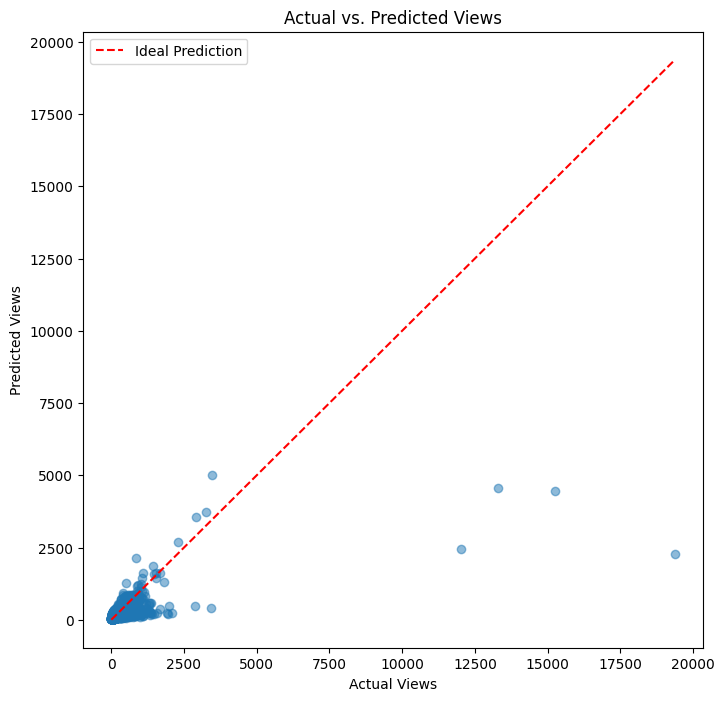

In [53]:
import matplotlib.pyplot as plt

# Convert predictions to Pandas DataFrame for visualization
predictions_pandas = predictions.select("num_views", "prediction").toPandas()

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(predictions_pandas["num_views"], predictions_pandas["prediction"], alpha=0.5)
plt.plot([predictions_pandas["num_views"].min(), predictions_pandas["num_views"].max()],
         [predictions_pandas["num_views"].min(), predictions_pandas["num_views"].max()],
         color='red', linestyle='--', label="Ideal Prediction")
plt.xlabel("Actual Views")
plt.ylabel("Predicted Views")
plt.title("Actual vs. Predicted Views")
plt.legend()
plt.show()


Then we examine the residuals (differences between actual and predicted values) to understand model bias and variance.

+-------+-------------------+
|summary|           residual|
+-------+-------------------+
|  count|              16772|
|   mean| 0.6216217512679393|
| stddev|  214.7021182315965|
|    min|-1553.3900000000003|
|    max|  17096.53060056283|
+-------+-------------------+



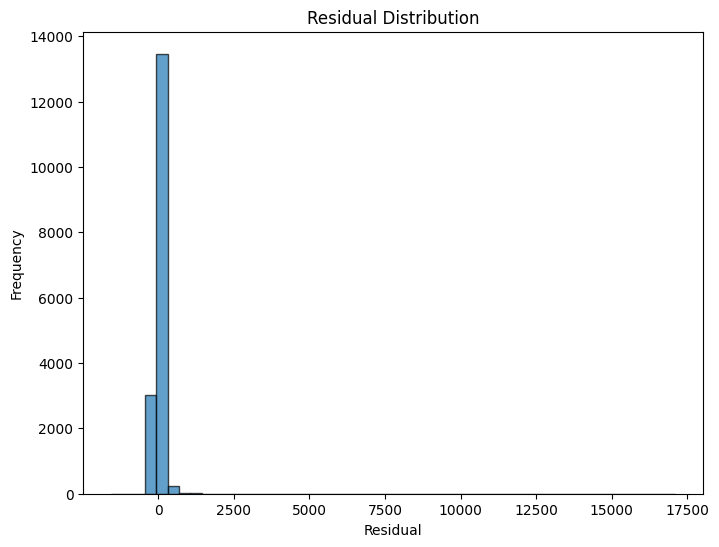

In [54]:
# Add residual column to predictions DataFrame
predictions = predictions.withColumn("residual", F.col("num_views") - F.col("prediction"))

# Show residual statistics
predictions.select("residual").describe().show()

# Convert residuals to Pandas for visualization
residuals_pandas = predictions.select("residual").toPandas()

# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals_pandas["residual"], bins=50, edgecolor="k", alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()
